# Google Trends Data for "Amazon" Search Term


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Import Data
df = pd.read_csv('amazon_gt.csv', skiprows=1, index_col='Month')
df.rename(columns={'amazon: (United States)': 'amazon'}, inplace=True)
df.index = pd.to_datetime(df.index)

# Introduction

We selected google trends data for the term 'Amazon' from 2004 to the present. This is a monthly series reflecting the relative search volume of Amazon normalized such that the max volume is reflected as 100 for any given period. Visually, the series shows an increasing trend over time and also displays clear seasonality. This seems intuitive since Amazon has grown to become the largest e-commerce retailer over time and we expect a higher volume of searches during the holiday season. We attempt to model this trend and seasonality to make predictions of the number of web searches for Amazon in the next 12 months.  

### 1a. Show a time series plot of the data

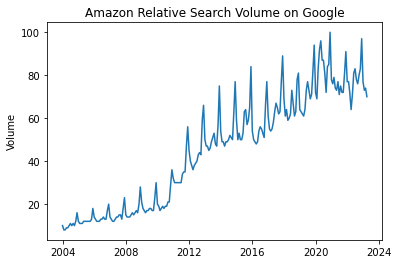

In [3]:
# 1a. Show a time series plot of the data
plt.title('Amazon Relative Search Volume on Google')
plt.ylabel('Volume')
plt.plot(df['amazon'])

The series does not appear wholly additive or multiplicative in nature. Before 2011 there appears to be a linear and multiplicative trend (higher seasonal spikes). Around 2011 there appears to be a shift in the intercept of the trend and thereafter the seasonal variation looks roughly the same magnitude. 

We perform a log transformation to regularize the seasonal volatility in the before-2011 and after-2011 periods.

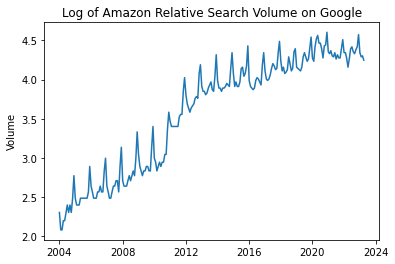

In [4]:
# Log transformed data
plt.title('Log of Amazon Relative Search Volume on Google')
plt.ylabel('Volume')
df['amazon'] = np.log(df['amazon'])
plt.plot(df['amazon'])

### 1b. Does your plot in (a) suggest that the data are covariance stationary? Explain your answer.

The series is not covariance stationary. The mean of the series is rising over time.

### 1c. Plot and discuss the ACF and PACF of your data.

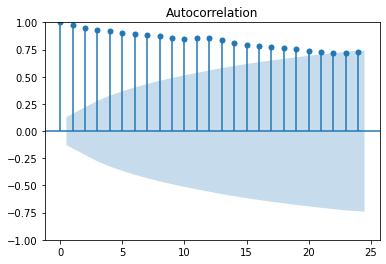

In [5]:
# Plot the ACF
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
plot_acf(df)
plt.show()

The amazon search series is significant and highly correlated with its lagged values out until nearly the two year mark.

/Users/talialieberman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


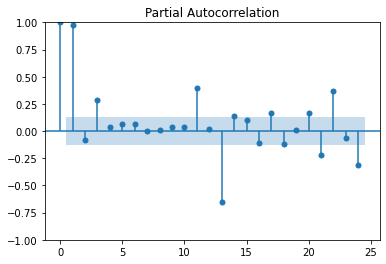

In [6]:
# Plot the PACF
plot_pacf(df)
plt.show()

The PACF results indicate significant partial autocorrelation at the one-month, quarterly, and annual lags.

### 1d. Fit a linear and nonlinear (e.g., polynomial, exponential, quadratic + periodic, etc.) model to your series. In one window, show both figures of the original times series plot with the respective fit.

In [7]:
# Decompositions
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition
decomposeM = seasonal_decompose(df['amazon'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
decomposeA = seasonal_decompose(df['amazon'], model='additive', extrapolate_trend='freq')

# Extract the Components 
# Actual Values = Product of (Seasonal * Trend * Resid)
df_M_comps = pd.concat([decomposeM.seasonal, decomposeM.trend, decomposeM.resid, decomposeM.observed], axis=1)
df_M_comps.columns = ['seas', 'trend', 'resid', 'actual_values']
# Actual Values = sum of
df_A_comps = pd.concat([decomposeA.seasonal, decomposeA.trend, decomposeA.resid, decomposeA.observed], axis=1)
df_A_comps.columns = ['seas', 'trend', 'resid', 'actual_values']

# View Residual Error
print('Multiplicative model MAPE: ', round(np.mean(abs(df_M_comps.resid) / df_M_comps.actual_values), 4))
print('Additive model MAPE: ',       round(np.mean(abs(df_A_comps.resid) / df_A_comps.actual_values), 4))

Multiplicative model MAPE:  0.2923
Additive model MAPE:  0.013


In [8]:
# Using the Additive model, seasonally adjust the series
data_seasAdj = df.amazon - decomposeA.seasonal

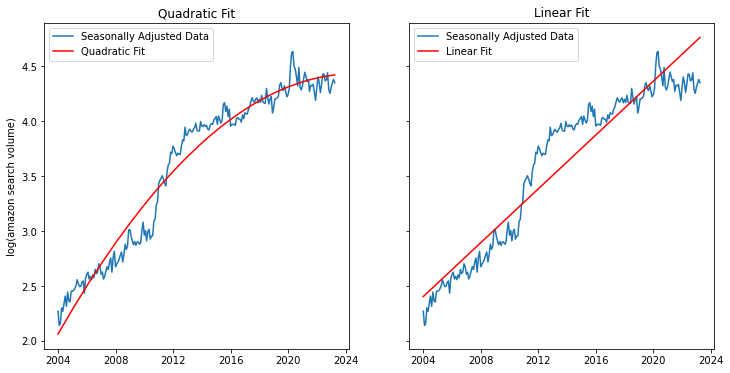

In [9]:
# Fit a quadratic trend
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

x_ts = df.index
y_ts = data_seasAdj
n = np.shape(y_ts)[0]  # n rows

# Quadratic Fit
t = range(n)
p_q = np.polyfit(t, y_ts, 2)
y_q = np.polyval(p_q,t)

# Linear Fit
t = range(n)
p_l = np.polyfit(t, y_ts, 1)
y_l = np.polyval(p_l,t)


# Create two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

# Quadratic
ax1.set_title('Quadratic Fit')
ax1.set_ylabel('log(amazon search volume)')
ax1.plot(x_ts, y_ts, label='Seasonally Adjusted Data')
ax1.plot(x_ts, y_q, color='r',label ='Quadratic Fit')
ax1.legend()

# Linear
ax2.set_title('Linear Fit')
ax2.plot(x_ts, y_ts, label='Seasonally Adjusted Data')
ax2.plot(x_ts, y_l, color='r',label ='Linear Fit')
ax2.legend()

### 1e. For each model, plot the respective residuals vs. fitted values and discuss your observations.

In [10]:
# Calculate Residuals
resid_q = data_seasAdj - np.polyval(p_q,t)
resid_l = data_seasAdj - np.polyval(p_l,t)

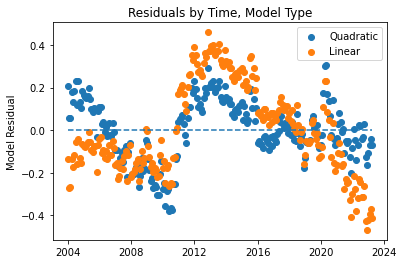

In [11]:
# Plot
plt.title("Residuals by Time, Model Type")
plt.hlines(y=0, xmin=df.index.min(), xmax=df.index.max(), linestyle='dashed')
plt.ylabel('Model Residual')
plt.scatter(df.index, resid_q, label='Quadratic')
plt.scatter(df.index, resid_l, label='Linear')
plt.legend()
plt.show()

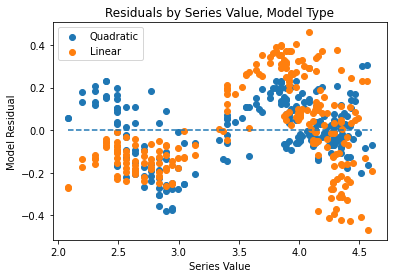

In [12]:
# Plot
plt.title("Residuals by Series Value, Model Type")
plt.xlabel('Series Value')
plt.ylabel('Model Residual')
plt.hlines(y=0, xmin=df.values.min(), xmax=df.values.max(), linestyle='dashed')
plt.scatter(df.values, resid_q, label='Quadratic')
plt.scatter(df.values, resid_l, label='Linear')
plt.legend()
plt.show()

There are clear patterns in the residuals which suggests the current models can be improved. Residuals over time show an oscillation between overestimating and then underestimating series values. This is largely a result of the jump in the series that occurs in 2011.

Residuals by series value demonstrates an underestimation of low values and an overestimation of medium values. The highest values appear equally likely to be over- or underestimated. 

In both plots the quadratic model exhibits lower averge residuals.

### 1f. For each model, plot a histogram of the residuals and discuss your observations

/Users/talialieberman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Linear Residuals')

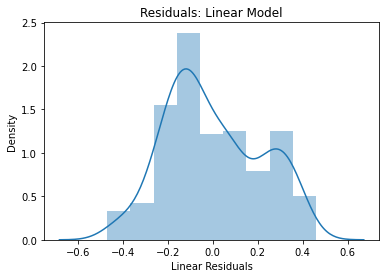

In [13]:
#plot histogram for linear model residuals
import seaborn as sns
sns.distplot(resid_l)
plt.title("Residuals: Linear Model")
plt.xlabel('Linear Residuals')

/Users/talialieberman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Quadratic Residuals')

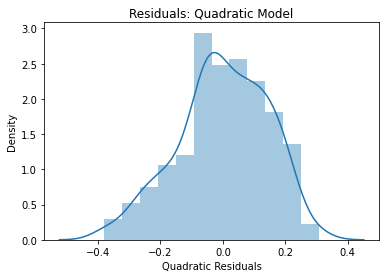

In [14]:
#plot histogram for quadratic model residuals
import seaborn as sns
sns.distplot(resid_q)
plt.title("Residuals: Quadratic Model")
plt.xlabel('Quadratic Residuals')

The residuals of both models do not appear to be normally distributed. The residuals of the quaratic model seem slightly more normal and centered around 0. The histogram of the linear model residuals confirm that there is an additional pattern exhibited.

### 1g. For each model, discuss the associated diagnostic statistics (R2, t−distribution, F−distribution, etc.)

In [15]:
#Diagnostics using polyfit: R2 for linear
r2_q = r2_score(y_ts, y_l)
print(r2_q)

0.9137391872485705


In [16]:
#Diagnostics using polyfit: R2 for quadratic
r2_q = r2_score(y_ts, y_q)
print(r2_q)

0.9603641716720053


In [17]:
from sklearn.preprocessing import PolynomialFeatures

#t stat and f stat for linear fit
X_lin = np.array(t).reshape(-1,1)
reg_l = LinearRegression().fit(X_lin, y_ts)
y_l_fit = reg_l.predict(X_lin)
mse_l = mean_squared_error(y_ts, y_l_fit)
r2_l = r2_score(y_ts, y_l_fit)
n_l, k_l = X_lin.shape
t_l = reg_l.coef_ / np.sqrt(mse_l / np.sum((X_lin - X_lin.mean(axis=0))**2, axis=0))
f_l = (r2_l / k_l) / ((1 - r2_l) / (n_l - k_l - 1))
print("Linear Fit:")
print("t-statistic: ", t_l)
print("F-statistic: ", f_l)

Linear Fit:
t-statistic:  [49.57335878]
F-statistic:  2436.332401281351


In [18]:
#t stat and f stat for quadratic fit
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(np.array(t).reshape(-1,1))
reg_q = LinearRegression().fit(X_poly, y_ts)
y_q_fit = reg_q.predict(X_poly)
mse_q = mean_squared_error(y_ts, y_q_fit)
n_q, k_q = X_poly.shape
t_q = reg_q.coef_ / np.sqrt(mse_q / np.sum((X_poly - X_poly.mean(axis=0))**2, axis=0))
f_q = (r2_q / k_q) / ((1 - r2_q) / (n_q - k_q - 1))
print("Quadratic Fit:")
print("t-statistic: ", t_q)
print("F-statistic: ", f_q)

Quadratic Fit:
t-statistic:  [  0.         136.84079349 -65.81520025]
F-statistic:  1841.4570888511319


/var/folders/_9/0pcw32b15m70tyjpxdx6wc_m0000gn/T/ipykernel_50363/1939585937.py:8: RuntimeWarning: divide by zero encountered in true_divide
  t_q = reg_q.coef_ / np.sqrt(mse_q / np.sum((X_poly - X_poly.mean(axis=0))**2, axis=0))


In [19]:
#Diagnostics using statsmodels:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
#linear model
t = np.arange(n)
linear_model = smf.ols(formula='y_ts ~ t', data=df)
results_l = linear_model.fit()
print(results_l.summary())

                            OLS Regression Results                            
Dep. Variable:                   y_ts   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     2436.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):          2.28e-124
Time:                        16:21:10   Log-Likelihood:                 32.591
No. Observations:                 232   AIC:                            -61.18
Df Residuals:                     230   BIC:                            -54.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4041      0.028     86.984      0.0

In [22]:
#quadratic model
t = np.arange(n)
quadratic_model = smf.ols(formula='y_ts ~ t + np.power(t, 2)', data=df)
results_q = quadratic_model.fit()
print(results_q.summary())

                            OLS Regression Results                            
Dep. Variable:                   y_ts   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     2774.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):          3.03e-161
Time:                        16:21:17   Log-Likelihood:                 122.80
No. Observations:                 232   AIC:                            -239.6
Df Residuals:                     229   BIC:                            -229.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0629      0.028     73.

The R-squared value for the quadratic model is 0.96, which is better than the R-squared of the linear model, which is 0.94. As we can see graphically, the model with a quadratic trend fits the data better than the linear trend.

In both models, the p-values of the time coefficients are significant, and the F-statistics are significantly large, indicating that both trends fit the data relatively well. 

### 1h. Select a trend model using AIC and one using BIC (show the values obtained from each criterion). Do the selected models agree?

In [23]:
print(results_q.aic)
print(results_q.bic)

-239.59580052701375
-229.25558841201482


In [24]:
print(results_l.aic)
print(results_l.bic)

-61.18286851798547
-54.28939377465285


In both cases, the quadratic model has a lower AIC and BIC, and therefore both metrics agree that the quadratic trend model is stronger.

### 1i. Use your preferred model to forecast h-steps (at least 12) ahead. Your forecast should include the respective uncertainty prediction interval. Depending on your data, h will be in days, months, years, etc.

1     4.425745
2     4.426869
3     4.427916
4     4.428886
5     4.429779
6     4.430595
7     4.431333
8     4.431995
9     4.432580
10    4.433087
11    4.433518
12    4.433871
dtype: float64


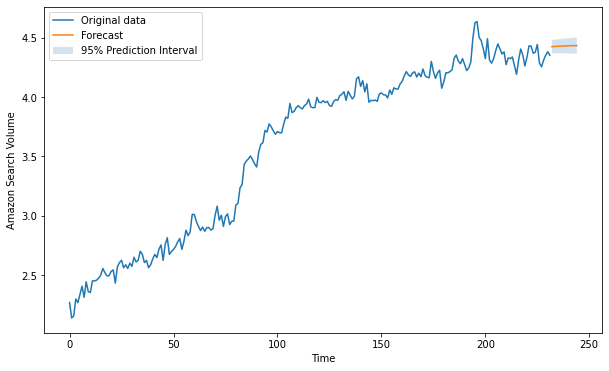

In [53]:
h = 12
# Create time variable with 12 steps ahead
t_pred = np.arange(n, n+h+1)

# Create DataFrame with new t values
df_pred = pd.DataFrame({'t': t_pred})

# Predict Y values for t_pred using quadratic trend model
y_pred = results_q.predict(df_pred)

#Find prediction interval for forecasts
pred_results = results_q.get_prediction(df_pred)
pred_int = pred_results.summary_frame(alpha=0.05)

# Print 12-step ahead forecast
forecast = y_pred.tail(h)
print(forecast)

# Plot original data and forecast
plt.figure(figsize=(10, 6))
plt.plot(t, df['y_ts'], label='Original data')
plt.plot(t_pred, y_pred, label='Forecast')
#plot prediction interval

plt.fill_between(t_pred, pred_int['mean_ci_lower'], pred_int['mean_ci_upper'], alpha=0.2, label='95% Prediction Interval')


plt.legend()
plt.xlabel('Time')
plt.ylabel('Amazon Search Volume')
plt.show()

## Q2. Trend and Seasonal Adjustments

### 2. (a) Perform an additive decomposition of your series. Remove the trend and seasonality, and comment on the ACF and PACF of the residuals (i.e., what is left after detrending and seasonally adjusting the series). Comment on the results.

### Additive:

Text(0.5, 0.98, 'Additive Decomposition')

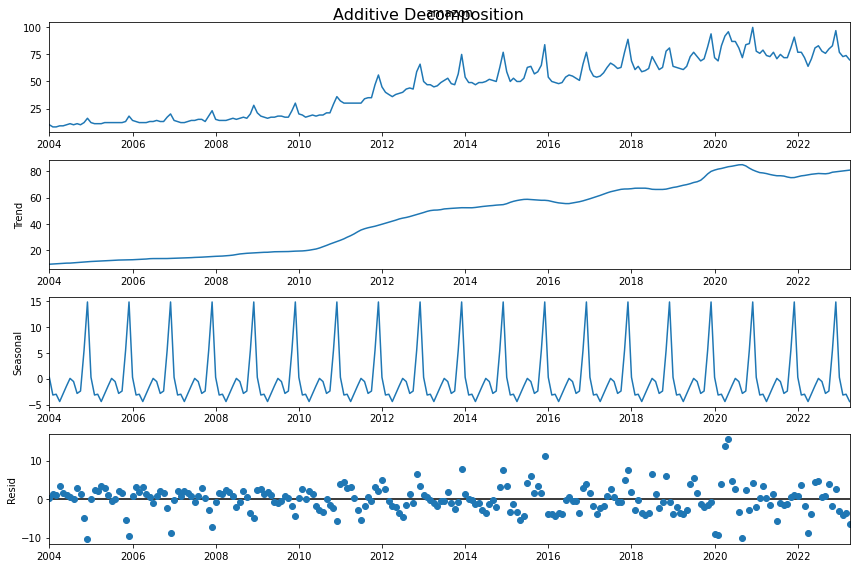

In [6]:
# Decomposing the series 
decomposeA = seasonal_decompose(df["amazon"], model='additive', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
decomposeA.plot().suptitle('Additive Decomposition', fontsize=16)

The residual after an Additive decomposition does not look randomly scattered around 0, neither is the variance constant. This suggests there is still some pattern left over after the decomposition that can be modelled. 

Text(0.5, 1.0, 'Detrended and Seasonally Adjusted Series')

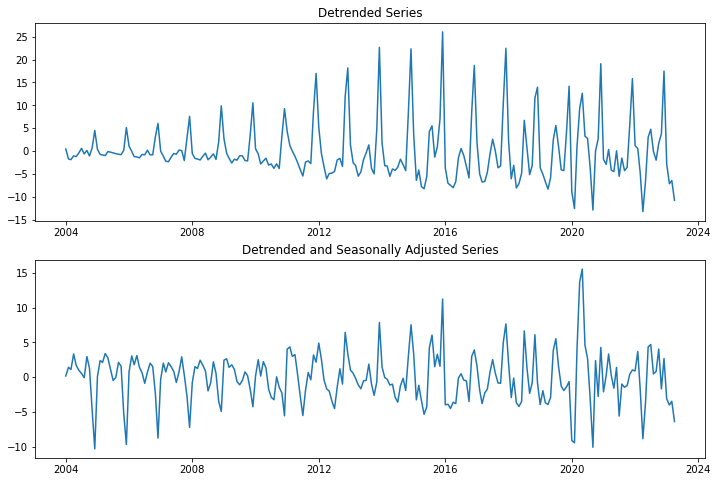

In [19]:
fig, ax = plt.subplots(2,1)

# Detrending
detrendedA = df["amazon"] - decomposeA.trend
ax[0].plot(detrendedA)
ax[0].set_title("Detrended Series")

# Seasonal Adjustment
dtdsA = detrendedA - decomposeA.seasonal
ax[1].plot(dtdsA)
ax[1].set_title("Detrended and Seasonally Adjusted Series")

After detrending and deseasonalizing, visually at least, the series seems to be mean reverting with some persistence. The variance isn't perfectly constant. The ACF and PACF will help us confirm if the remainder is white noise.

/Users/rheasethi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


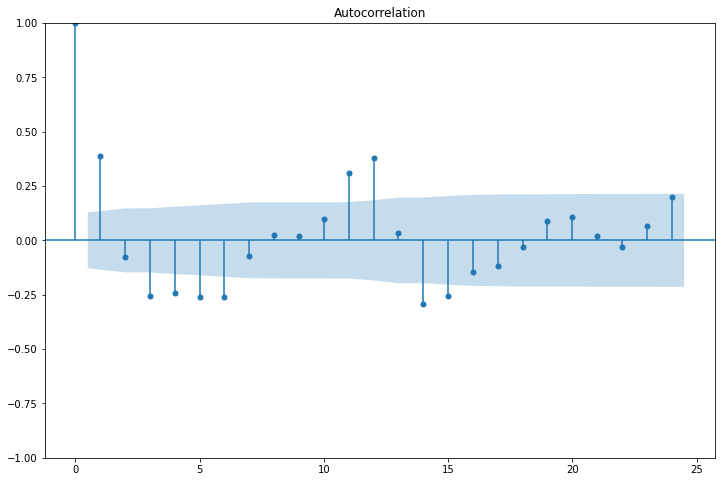

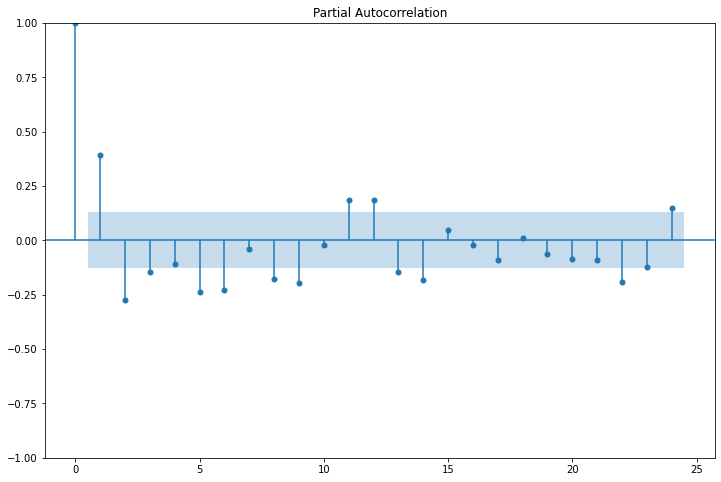

In [227]:
# ACF and PACF of residual
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot

plot_acf(dtdsA);
plot_pacf(dtdsA);

Both the ACF and the PACF show significant spikes that cross the band suggesting there is still some left over seasonality in the remainder that has not been extracted by the decomposition. In the ACF, there are 9 significant spikes with the last one being at lag 15. We would use these lags in an MA model for modelling cycles.

### 2. (b) Perform a multiplicative decomposition of your series. Remove the trend and seasonality, and comment on the ACF and PACF of the residuals (i.e., what is left after detrending and seasonally adjusting the series). Comment on the results.

### Multiplicative:

Text(0.5, 0.98, 'Multiplicative Decomposition')

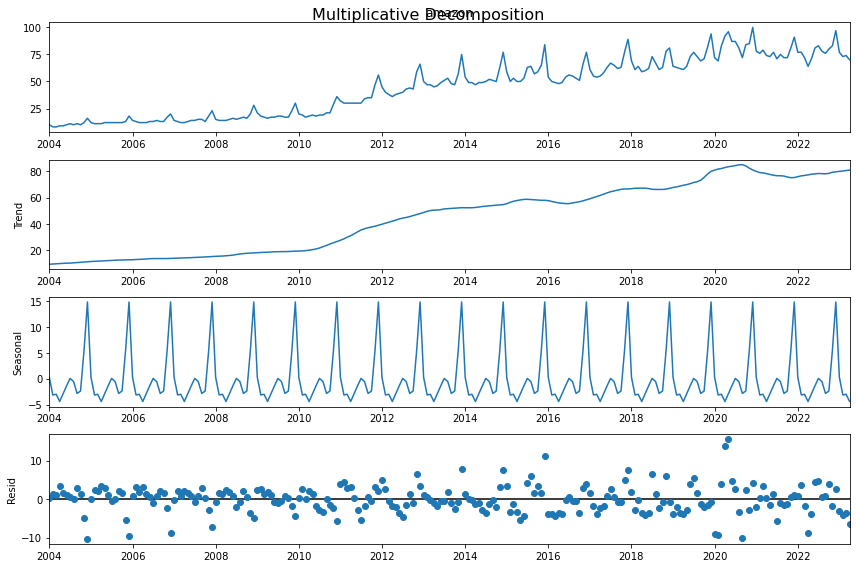

In [20]:
#Decomposing the series 

decomposeM = seasonal_decompose(df["amazon"], model='multiplicative', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
decomposeA.plot().suptitle('Multiplicative Decomposition', fontsize=16)

The residual from a Multiplicative decomposition also displays the same properties as that from an Additive decomposition. The pattern suggests the remainder is still not representative of white noise.

In [230]:
# Detrending
detrendedM = df["amazon"]/decomposeM.trend
detrendedM.plot()

# Seasonal Adjustment
dtdsM = detrendedM/decomposeM.seasonal
dtdsM.plot()

Text(0.5, 1.0, 'Detrended and Seasonally Adjusted Series')

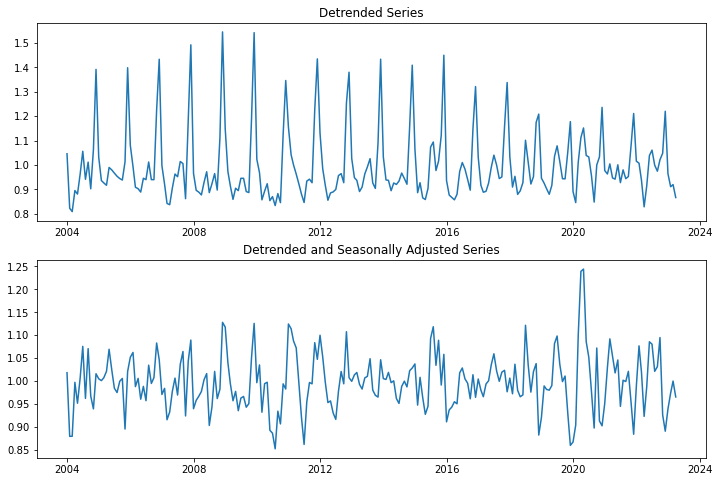

In [21]:
fig, ax = plt.subplots(2,1)

# Detrending
detrendedM = df["amazon"]/decomposeM.trend
ax[0].plot(detrendedM)
ax[0].set_title("Detrended Series")

# Seasonal Adjustment
dtdsM = detrendedM/decomposeM.seasonal
ax[1].plot(dtdsM)
ax[1].set_title("Detrended and Seasonally Adjusted Series")

The Detrended and Seasonally Adjusted series after a multiplicative decomposition seems to be mean reverting but with higher persistence. However, the variance seems to be more constant compared to the Additive Decomposition.
We look at the ACF and PACF again to check if this is a white noise process.

/Users/rheasethi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


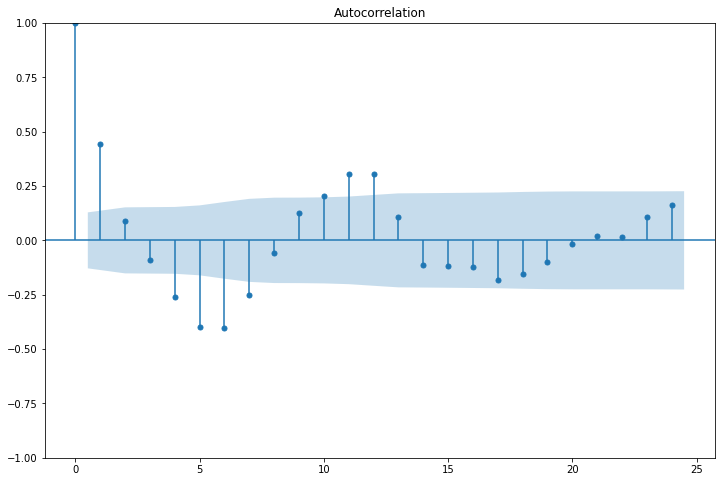

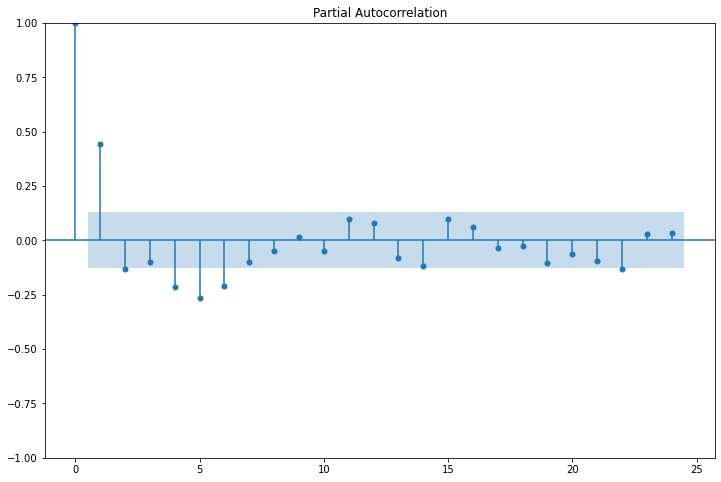

In [234]:
# ACF and PACF of residual

plot_acf(dtdsM);
plot_pacf(dtdsM);

The ACF and PACF again show significant spikes that cross the band, suggesting that this decomposition doesn't result in a pure white noise process either. However, looking at the ACF, we see fewer spikes compared to the Additive Decomposition. This implies the Multiplicative Decomposition could be the preferred choice.

### 2.(c) Which decomposition is better, additive or multiplicative? Why?

Though there is still some pattern left over after the Multiplicative Decomposition, the ACF and PACF plots show fewer significant spikes as compared to the Additive Decomposition. As such, the Multiplicative Decomposiiton is doing a relatively better job at extracting the predictable compnents of the series in the form of trend and seasonality. Therefore, we choose Multiplicative Decomposition to model the remainder.

### 2.(d) Based on the two decompositions, and interpretation of the random components, would your models for the cycles be similar (additive vs. multiplicative) or very different? Why?

For modelling cycles we could use the Moving Average process of order 'q'. The residual plots after decomposing the series through Additive and Multiplicative models have very similar profiles. However, looking at the ACF (and PACF), we can see that there will be minor differences in the order of the MA model for the Additive and Multiplicative models.

For the Additive, the ACF shows significant spikes for 9 lags whereas for the Multiplicative Model, it does so for 7. We would have 2 more lag variables in our MA model if we were to use the Additive decomposition.

The equations of the two models would look like this:

* Additive : $$Y_t = \mu + θ_{1}\epsilon_{t-1} + θ_{3}\epsilon_{t-3} + θ_{4}\epsilon_{t-4} + θ_{5}\epsilon_{t-5} + θ_{6}\epsilon_{t-6}+ θ_{11}\epsilon_{t-11} + θ_{12}\epsilon_{t-12} + θ_{14}\epsilon_{t-14} + θ_{15}\epsilon_{t-15} + \epsilon$$

* Multiplicative : $$Y_t = \mu + θ_{1}\epsilon_{t-1} + θ_{4}\epsilon_{t-4} + θ_{5}\epsilon_{t-5} + θ_{6}\epsilon_{t-6} + θ_{7}\epsilon_{t-7}+ θ_{11}\epsilon_{t-11} + θ_{12}\epsilon_{t-12} + \epsilon$$

The Multiplicative model has fewer lag variables and so is the preferred model according to the Parsimony principle. We also see that the PACF of the Multiplicative model shows a clearer decay to 0 which is a sign of an MA process. This also corroborates our choice of the multiplicative decomposition as the better model.

### 2.(e) Plot the seasonal factors and comment on the plot.

In [23]:
# We create seasonal dummies using Months
df['Month'] = df.index.month_name()

<AxesSubplot:xlabel='Month', ylabel='amazon'>

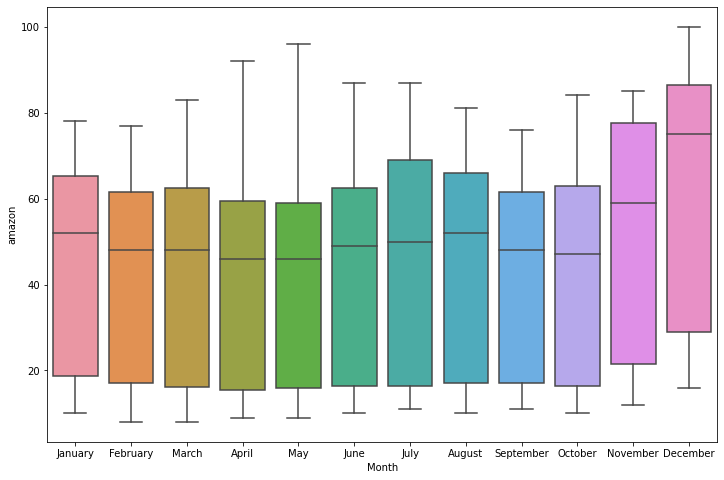

In [24]:
# Making a boxplot for monthly seasonality (Preliminary analysis)
sns.boxplot(x='Month', y='amazon', data=df)

The above boxplots show a higher median for November and December. This suggests an increase in web searches for "Amazon" during holiday months. We try to confirm in the subsequent analysis.

We use the detrended series from the Multiplicative Decomposition model to better gauge the effect of seasonal factors 

In [25]:
# Fitting an OLS using Monthly dummies
ols = smf.ols('detrendedM ~ Month', data = df).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             detrendedM   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     78.04
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           1.36e-69
Time:                        16:50:57   Log-Likelihood:                 310.60
No. Observations:                 232   AIC:                            -597.2
Df Residuals:                     220   BIC:                            -555.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8956      0.015     61.483      0.000       0.867       0.924
Month[T.August]        0.0804      0.021      3.850      0.000       0.039       0.121
Month[T.December]      0.4708      0.021     22.560      0.000       0.430       0.512
Month[T.February]      0.0376      0.021      1.825      0.069      -0.003       0.078
Month[T.January]       0.1292      0.021      6.272      0.000       0.089       0.170
Month[T.July]          0.0839      0.021      4.022      0.000       0.043       0.125
Month[T.June]          0.0588      0.021      2.818      0.005       0.018       0.100
Month[T.March]         0.0220      0.021      1.067      0.287      -0.019       0.063
Month[T.May]           0.0278      0.021      1.333      0.184      -0.013       0.069
Month[T.November]      0.2332      0.021     11.174      0.000       0.192       0.274
Month[T.October]       0.0351      0.021      1.682      0.094      -0.006       0.076
Month[T.September]     0.0470      0.021      2.250      0.025       0.006       0.088
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.161
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               16.252
Skew:                           0.267   Prob(JB):                     0.000296
Kurtosis:                       4.182   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

April is dropped (to avoid the dummy variable trap) and is thus taken as the baseline. 
We see that some months' dummies are statistically insignificant (March, May, February) but we keep them for completeness and to trace the path of seasonality over the entire year.

In [26]:
# Plotting coefficient estimates of month dummies

monthly_coefs = ols.params[1:]

In [27]:
# Extracting month names from coefficients index
month_names = [col.split('[')[1].split(']')[0].split('T.')[1] for col in monthly_coefs.index if 'Month[' in col]

print(month_names)

['August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']


In [28]:
# Resetting the index
monthly_coefs.index = month_names

In [29]:
monthly_coefs

August       0.080351
December     0.470824
February     0.037587
January      0.129205
July         0.083935
June         0.058811
March        0.021988
May          0.027828
November     0.233196
October      0.035110
September    0.046965
dtype: float64

Text(0.5, 1.0, 'Seasonal Factor')

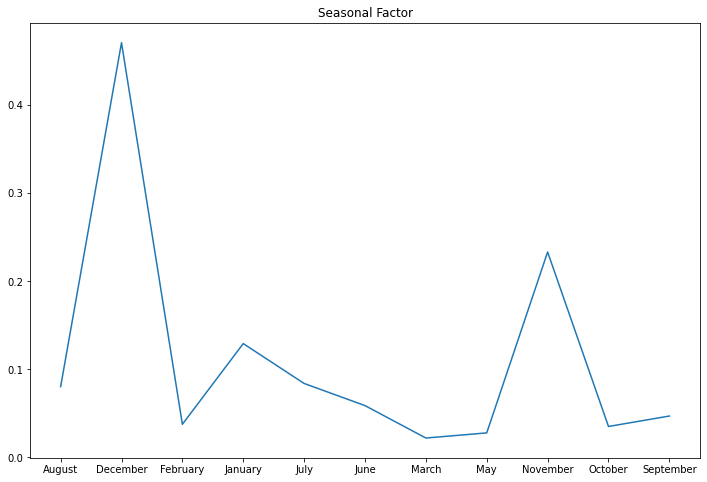

In [30]:
# Plotting the seasonal dummies

plt.plot(monthly_coefs)
plt.title("Seasonal Factor")

We can see that the coefficients on holiday months, i.e., November and December are much higher than the other months. This observation is in line with what we saw in the boxplots above. Holiday Months seem to heavily influence the number of searches for Amazon.

### 2.(f) Based on your analysis thus far, choose a model that includes your preferred trend a seasonal model to forecast 12-steps ahead, and show the plot of the data, respective fit, and forecast.

In [31]:
# Creating a new column for time
t = np.arange(0, len(df))
df["Time"] = t

In [32]:
df

,amazon,Month,Time
Month,,,
2004-01-01,10,January,0
2004-02-01,8,February,1
2004-03-01,8,March,2
2004-04-01,9,April,3
2004-05-01,9,May,4
...,...,...,...
2022-12-01,97,December,227
2023-01-01,77,January,228
2023-02-01,73,February,229


### Making the Forecast

In [46]:
# Supply the starting date and the end date for the forecast horizon
dates = pd.date_range(start = '2023-05-01', end = '2024-4-01', freq = 'MS')

# Get the names of each month for the forecast horizon
month = dates.month_name()

# Get the trend variable for the forecast horizon, starting at the end of the original
t = np.arange(232, 232+12)

# Put into a format accepted by statsmodels
new = pd.DataFrame({'Month': month, 'amazon' :np.ones(len(month)), 'Time' :t}, index = dates)

In [74]:
# Fitting an OLS model on the data we have

model = smf.ols('amazon ~ Month + Time + I(Time**2)', data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amazon   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     258.4
Date:                Mon, 24 Apr 2023   Prob (F-statistic):          1.70e-124
Time:                        17:48:29   Log-Likelihood:                -759.91
No. Observations:                 232   AIC:                             1548.
Df Residuals:                     218   BIC:                             1596.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.6810      1.900     -1.411      0.160      -6.426       1.064
Month[T.August]        3.9516      2.116      1.867      0.063      -0.220       8.123
Month[T.December]     19.0133      2.116      8.984      0.000      14.842      23.184
Month[T.February]      1.3827      2.088      0.662      0.509      -2.733       5.499
Month[T.January]       4.8494      2.088      2.322      0.021       0.733       8.966
Month[T.July]          4.6340      2.116      2.190      0.030       0.463       8.805
Month[T.June]          3.2641      2.116      1.542      0.124      -0.907       7.435
Month[T.March]         1.4662      2.088      0.702      0.483      -2.650       5.582
Month[T.May]           1.7365      2.117      0.820      0.413      -2.435       5.908
Month[T.November]      9.7476      2.116      4.606      0.000       5.577      13.919
Month[T.October]       1.9557      2.116      0.924      0.356      -2.215       6.127
Month[T.September]     1.5851      2.116      0.749      0.455      -2.586       5.756
Time                   0.3922      0.026     15.186      0.000       0.341       0.443
I(Time ** 2)          -0.0001      0.000     -1.031      0.304      -0.000       0.000
==============================================================================
Omnibus:                        6.181   Durbin-Watson:                   0.379
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.050
Skew:                           0.319   Prob(JB):                       0.0486
Kurtosis:                       3.468   Cond. No.                     2.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [76]:
# Predicting 12 steps ahead
preds = model.predict(new)

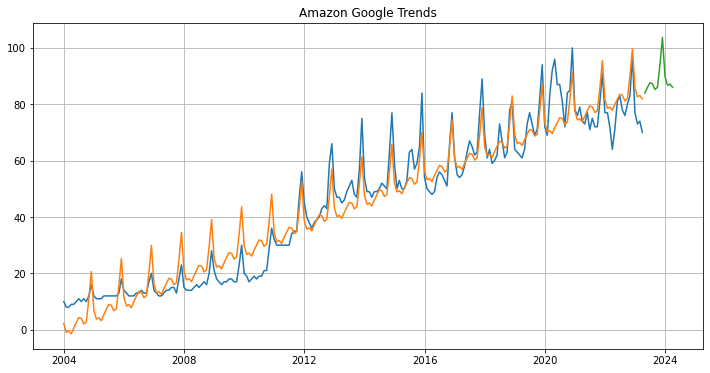

In [77]:
# Plotting observed, fitted and predicted values
plt.figure(figsize = (12, 6))
plt.title('Amazon Google Trends')
plt.plot(df.amazon)
plt.plot(model.fittedvalues) 
plt.plot(preds)
plt.grid()

The green line shows the 12-step ahead forecast that is predicted by our model. The number of web searches is predicted to follow an increasing trend and display the same seasonality as the rest of the fitted values.

### Evaluating Forecasting Performance 

In [78]:
# We take last 60 observations as our test data and the rest as training data
train = df.iloc[:-60]
test = df.iloc[-60:]

In [79]:
perform_res = smf.ols('amazon ~ Month + Time + I(Time**2)', data = train).fit()
perform_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amazon   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     160.9
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           6.04e-84
Time:                        17:49:27   Log-Likelihood:                -536.53
No. Observations:                 172   AIC:                             1101.
Df Residuals:                     158   BIC:                             1145.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.9081      1.897      1.006      0.316      -1.838       5.654
Month[T.August]        3.8882      2.124      1.830      0.069      -0.308       8.084
Month[T.December]     18.4087      2.124      8.665      0.000      14.213      22.605
Month[T.February]      1.8382      2.086      0.881      0.380      -2.283       5.959
Month[T.January]       5.6877      2.086      2.726      0.007       1.567       9.809
Month[T.July]          3.4853      2.125      1.641      0.103      -0.711       7.681
Month[T.June]          2.2947      2.125      1.080      0.282      -1.902       6.491
Month[T.March]         1.2534      2.086      0.601      0.549      -2.867       5.374
Month[T.May]           1.2450      2.125      0.586      0.559      -2.952       5.442
Month[T.November]      9.5851      2.124      4.512      0.000       5.389      13.781
Month[T.October]       1.6881      2.124      0.795      0.428      -2.508       5.884
Month[T.September]     2.5035      2.124      1.178      0.240      -1.692       6.699
Time                   0.2151      0.035      6.146      0.000       0.146       0.284
I(Time ** 2)           0.0010      0.000      5.007      0.000       0.001       0.001
==============================================================================
Omnibus:                        6.031   Durbin-Watson:                   0.372
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                3.455
Skew:                           0.128   Prob(JB):                        0.178
Kurtosis:                       2.354   Cond. No.                     1.60e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

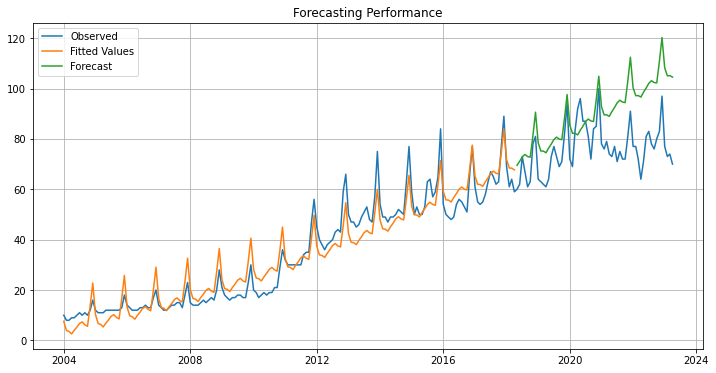

In [80]:
# Plotting observed, fitted and predicted values 
plt.figure(figsize = (12, 6))
plt.title('Forecasting Performance')
plt.plot(df.amazon)
plt.plot(perform_res.fittedvalues)
plt.plot(perform_res.predict(test))
plt.legend(['Observed', 'Fitted Values', 'Forecast'])
plt.grid()

The green line shows the values predicted by our model over the testing set. We can see that the predictions are higher than the observed values, implying that our model may be overestimating the number of searches.

In [ ]:
predictions = perform_res.predict(test)

In [66]:
# Compute forecast error
forecast_error = test.amazon - predictions

# Mean Forecast Error (bias)
forecast_error.mean()

-14.192692017878553

In [68]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test.amazon, predictions)

15.05659403456955

In [71]:
# Mean Squared Error
from sklearn.metrics import mean_squared_error

mean_squared_error(test.amazon, predictions)

307.5631085486973

In [72]:
# Mean Absolute Percentage Error

np.mean(np.abs((test.amazon - predictions) / test.amazon)) * 100

20.27743599936116

# Conclusions and Future Work

Our Final Model includes a quadratic time trend variable and monthly dummies as seasonal factors to try and predict the (scaled) number of web searches of the term "Amazon". 

Using these predictors we were able to model the trend and seasonality in our data, and explain 93.5% of the variation in our regressand as seen in the Adjusted $R^2$. 

The performance evaluation metrics of our model reveal a Mean Absolute Percentage Error of ~20%, indicating that our predictions for the 12-step ahead forecast may be off by so much. The Mean Forecast Error is negative which implies that our model's predictions are on average higher than the actual values. Keeping this in mind, our 12-step ahead forecast is probably overestimated by around 14 searches. 

We can minimize this error by trying to model the cycles in our data using an MA process. This will help extract everything that is predictable in our data and would ideally leave us with random white noise in the remainder. Combining trend, seasonal and cycle modelling should improve our model's forecasting accuracy.

# References

OpenAI. (2023). ChatGPT [Large language model]. https://chat.openai.com/chat

Google Trends (n.d.). “Amazon”. Retrieved April 2023, from https://trends.google.com/trends/explore?date=all&geo=US&q=%2Fm%2F0mgkg&hl=en

Kunz, N. (2023). Econ 412, Various Jupyter Notebooks. Retrieved from BruinLearn 

Rojas, R. (2023). Econ 412, Various Jupyter Notebooks. Retrieved from BruinLearn